In [54]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,6)

from keras import backend as K
import keras
from tensorflow.keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints

from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, Concatenate, Lambda, Average
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# Any results you write to the current directory are saved as output.

# prepare data

In [55]:
# load data

_df = pd.read_json('news_data.json', lines = True)
df = _df.drop(_df.columns[[0,4,5]], axis = 1)

In [56]:
cates = df.groupby('category')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 42
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4583
BUSINESS           5992
COLLEGE            1144
COMEDY             5400
CRIME              3562
CULTURE & ARTS     1074
DIVORCE            3426
EDUCATION          1014
ENTERTAINMENT     17362
ENVIRONMENT        1444
FIFTY              1401
FOOD & DRINK       6340
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4320
IMPACT             3484
LATINO VOICES      1130
MEDIA              2944
MONEY              1756
PARENTING          8791
PARENTS            3955
POLITICS          35602
QUEER VOICES       6347
RELIGION           2577
SCIENCE            2206
SPORTS             5077
STYLE              2254
STYLE & BEAUTY     9814
TASTE              2096
TECH               2104
THE WORLDPOST      3664
TRAVEL             9900
U.S. NEWS          1377
WEDDINGS           3653
WEIRD NEWS         2777
WELLNESS          17945
WOMEN              3572
WORLD NEWS

In [57]:
df['category'] = df['category'].astype('string')
df['headline'] = df['headline'].astype('string')
df['short_description'] = df['short_description'].astype('string')

In [58]:
df['headline'] = df['headline'].str.lower()
df['category'] = df['category'].str.lower()
df['short_description'] = df['short_description'].str.lower()


In [59]:
for index, row in df.iterrows():
    i = df['category'].at[index]
    
    if(i == "world news" or i == "the worldpost"):
        df['category'].at[index] = "worldpost" 
        
 
    if( i=="arts" or i == "arts & culture"):
        df['category'].at[index] = "culture & arts"
        
    if( i=="wellness"):
        df['category'].at[index] = "healthy living"
    
    if( i=="taste"):
        df['category'].at[index] = "food & drink"
   



    
# check that the species were converted correctly
df['category'].unique()

<StringArray>
[     'u.s. news',         'comedy',      'parenting',      'worldpost',
 'culture & arts',           'tech',         'sports',  'entertainment',
       'politics',     'weird news',    'environment',      'education',
          'crime',        'science', 'healthy living',       'business',
 'style & beauty',   'food & drink',          'media',   'queer voices',
  'home & living',          'women',   'black voices',         'travel',
          'money',       'religion',  'latino voices',         'impact',
       'weddings',        'college',        'parents',          'style',
          'green',      'good news',          'fifty',        'divorce']
Length: 36, dtype: string

In [60]:
# using headlines and short_description as input X

df['text'] = df.headline + " " + df.short_description

# tokenizing

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
X = tokenizer.texts_to_sequences(df.text)
df['words'] = X

# delete some empty and short data

df['word_length'] = df.words.apply(lambda i: len(i))
df = df[df.word_length >= 5]

df.head()

,headline,category,short_description,text,words,word_length
0,over 4 million americans roll up sleeves for o...,u.s. news,health experts said it is too early to predict...,over 4 million americans roll up sleeves for o...,"[70, 315, 274, 270, 2178, 48, 11363, 8, 20059,...",42
1,"american airlines flyer charged, banned for li...",u.s. news,he was subdued by passengers and crew when he ...,"american airlines flyer charged, banned for li...","[168, 1669, 11003, 1402, 3118, 8, 68, 57, 9596...",42
2,23 of the funniest tweets about cats and dogs ...,comedy,"""until you have a dog you don't understand wha...",23 of the funniest tweets about cats and dogs ...,"[1949, 4, 1, 1780, 752, 25, 2791, 5, 1180, 16,...",26
3,the funniest tweets from parents this week (se...,parenting,"""accidentally put grown-up toothpaste on my to...",the funniest tweets from parents this week (se...,"[1, 1780, 752, 22, 198, 16, 97, 4161, 1153, 19...",36
4,woman who called cops on black bird-watcher lo...,u.s. news,amy cooper accused investment firm franklin te...,woman who called cops on black bird-watcher lo...,"[218, 46, 335, 1379, 10, 171, 2523, 25172, 291...",38


In [61]:
df.word_length.describe()

count    208588.000000
mean         29.735752
std          13.783389
min           5.000000
25%          21.000000
50%          29.000000
75%          36.000000
max         248.000000
Name: word_length, dtype: float64

In [62]:
# using 50 for padding length
from keras_preprocessing.sequence import pad_sequences

maxlen = 50
X = list(pad_sequences(df.words, maxlen=maxlen))

In [63]:
# category to id

categories = df.groupby('category').size().index.tolist()
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

df['c2id'] = df['category'].apply(lambda x: category_int[x])

C:\Users\ALI\AppData\Local\Temp\ipykernel_23156\638792572.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c2id'] = df['category'].apply(lambda x: category_int[x])


# glove embedding

In [64]:
word_index = tokenizer.word_index


embeddings_index = {}
f = open('glove.6B.50d.txt',encoding = 'utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s unique tokens.' % len(word_index))
print('Total %s word vectors.' % len(embeddings_index))

Found 120405 unique tokens.
Total 400000 word vectors.


In [65]:
EMBEDDING_DIM = 50


embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

In [66]:
X = np.array(X)
Y = np_utils.to_categorical(list(df.c2id))


In [67]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=True):
    if multi_class:
        # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
        if one_hot_encoded:
            class_series = np.argmax(class_series, axis=1)

        # Compute class weights with sklearn method
        class_labels = np.unique(class_series)
        class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
        return dict(zip(class_labels, class_weights))
    else:
        # It is neccessary that the multi-label values are one-hot encoded
        mlb = None
        if not one_hot_encoded:
            mlb = MultiLabelBinarizer()
            class_series = mlb.fit_transform(class_series)

        n_samples = len(class_series)
        n_classes = len(class_series[0])

        # Count each class frequency
        class_count = [0] * n_classes
        for classes in class_series:
            for index in range(n_classes):
                if classes[index] != 0:
                    class_count[index] += 1

        # Compute class weights using balanced method
        class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
        class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
        return dict(zip(class_labels, class_weights))

In [68]:
from sklearn.utils import class_weight
class_weights = generate_class_weights(Y)

# class_weights 


# split dataset

In [69]:
# and split to training set and validation set

seed = 2
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)

# LSTM with Attention

In [70]:
# from https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043/code

class AttentionLayer(Layer):
    
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        """
        
        self.supports_masking = True
        self.init = keras.initializers.get('glorot_uniform')

        self.W_regularizer = keras.regularizers.get(W_regularizer)
        self.b_regularizer = keras.regularizers.get(b_regularizer)

        self.W_constraint = keras.constraints.get(W_constraint)
        self.b_constraint = keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)
        

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True
        

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    
    def call(self, x, mask=None):
        # TF backend doesn't support it
        # eij = K.dot(x, self.W) 
        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), 
                              K.reshape(self.W, (features_dim, 1))),
                        (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        
        return K.sum(weighted_input, axis=1)

    
    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    
    
    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    

In [71]:
lstm_layer = LSTM(50, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)

inp = Input(shape=(maxlen,), dtype='int32')
embedding= embedding_layer(inp)
x = lstm_layer(embedding)
x = Dropout(0.2)(x)
merged = AttentionLayer(maxlen)(x)
merged = Dense(192, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)
outp = Dense(len(int_category), activation='softmax')(merged)

AttentionLSTM = Model(inputs=inp, outputs=outp)
AttentionLSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

AttentionLSTM.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 50)            6020300   
                                                                 
 lstm_8 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_11 (Dropout)        (None, 50, 50)            0         
                                                                 
 attention_layer_8 (Attentio  (None, 50)               100       
 nLayer)                                                         
                                                                 
 dense_16 (Dense)            (None, 192)               9792      
                                                           

In [73]:
attlstm_history = AttentionLSTM.fit(x_train, 
                                    y_train, 
                                    batch_size=80, 
                                    epochs=15, 
                                    validation_data=(x_val, y_val),
                                   class_weight = class_weights)

#  I lost the charts for 100D Glove which performs a lot better about 5 to 8 percent (Generalized)

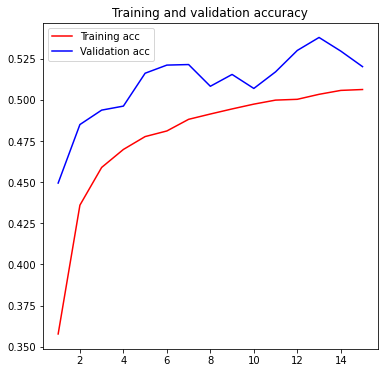

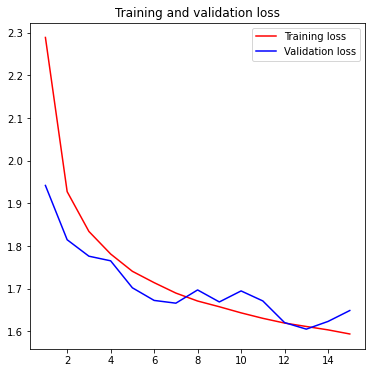

In [50]:
acc = attlstm_history.history['acc']
val_acc = attlstm_history.history['val_acc']
loss = attlstm_history.history['loss']
val_loss = attlstm_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

In [51]:
y_pred_test_ = AttentionLSTM.predict(x_val)
y_pred_train_ = AttentionLSTM.predict(x_train)

5215/5215 [==============================] - 65s 13ms/step


In [53]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_pred_test = cont_to_bin(y_pred_test_)
y_pred_train = cont_to_bin(y_pred_train_)


score_f1_test = f1_score(y_val, y_pred_test,average = 'weighted')
score_f1_train = f1_score(y_train, y_pred_train,average = 'weighted')

score_f1_test_micro = f1_score(y_val, y_pred_test,average = 'micro')
score_f1_train_micro = f1_score(y_train, y_pred_train,average = 'micro')


print("Training Evaluation")
print("Weighted F1-Score: ", score_f1_train)
print("Micro F1-Score: ", score_f1_train_micro)


print('-' * 20)

print("Weighted F1-Score: ", score_f1_test)
print("Micro F1-Score: ", score_f1_test_micro)


Training Evaluation
Weighted F1-Score:  0.5541527439537866
Micro F1-Score:  0.5334991310601067
--------------------
Weighted F1-Score:  0.5428597040472852
Micro F1-Score:  0.5202310753152116


In [81]:
# confusion matrix

# predicted = AttentionLSTM.predict(x_val)
# cm = pd.DataFrame(confusion_matrix(y_val.argmax(axis=1), y_pred_test.argmax(axis=1)))

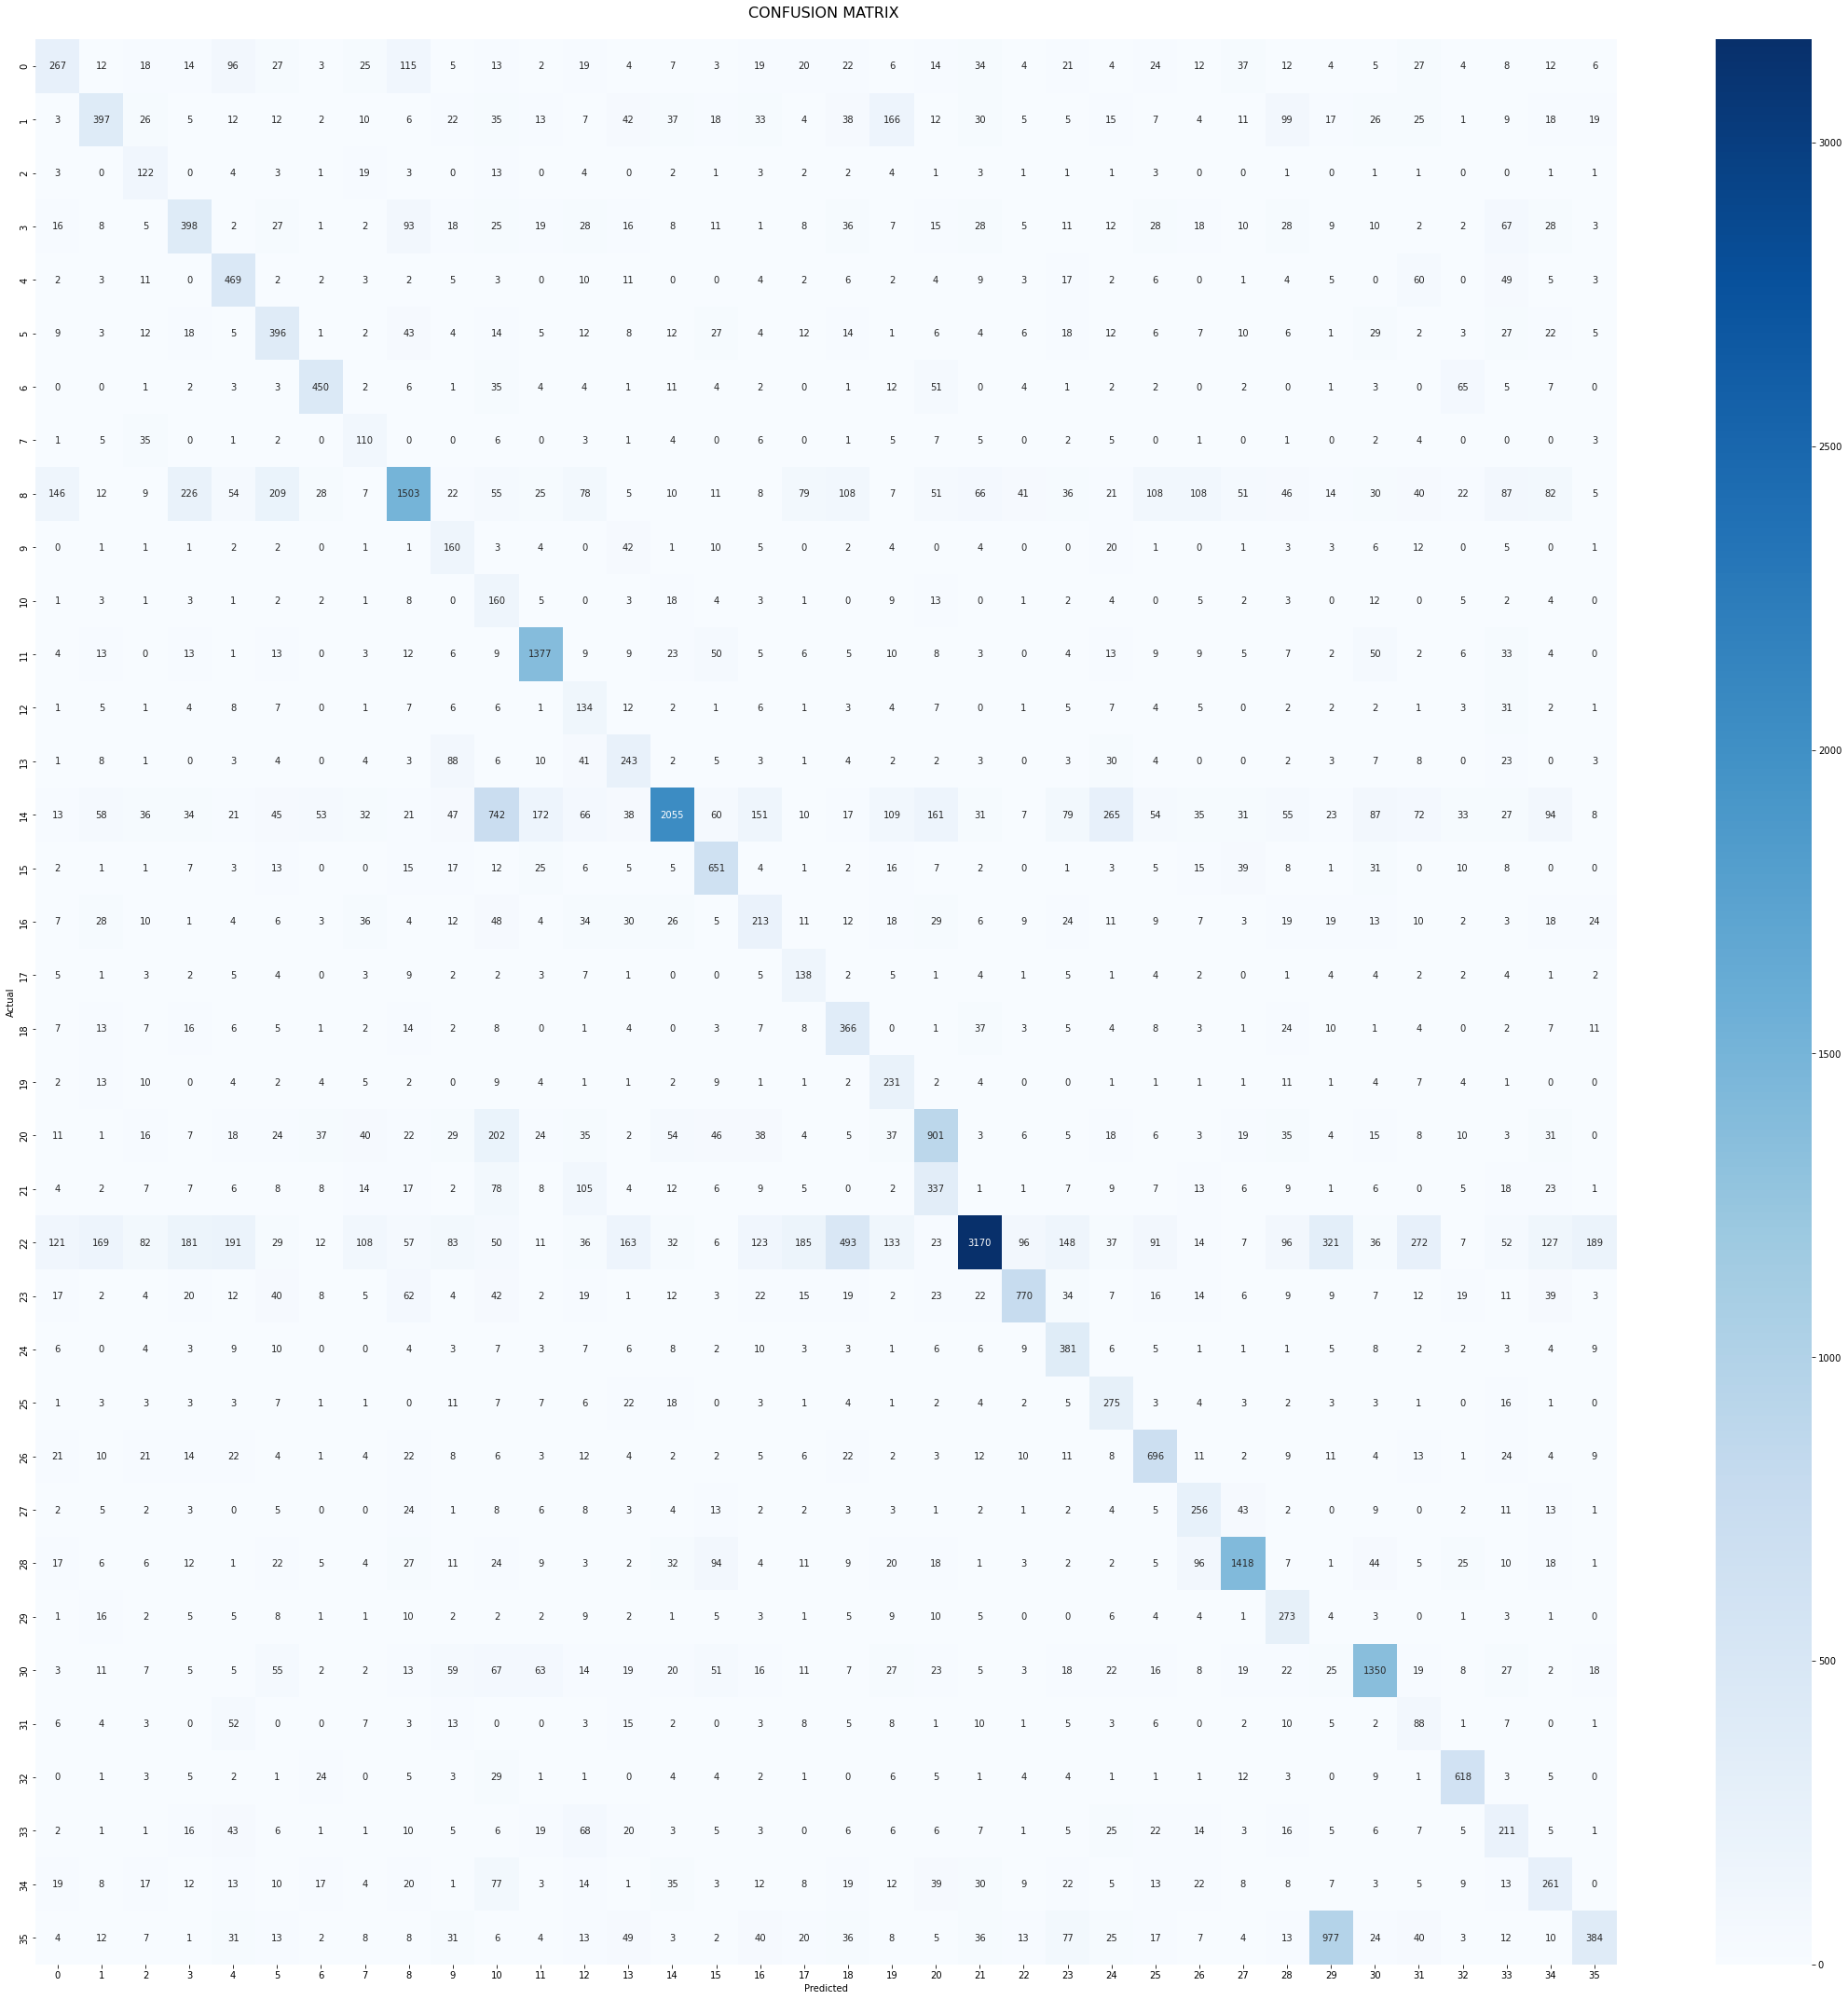

In [84]:
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix


conf_mat = pd.DataFrame(confusion_matrix(y_val.argmax(axis=1), y_pred_test.argmax(axis=1)))
fig, ax = plt.subplots(figsize=(38,38))

sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX \n", size=16);

In [40]:
def cont_to_bin(_2darr):
    #make an 2d array
    final2d = np.empty(_2darr.shape,dtype = int)
    
    #iterate over each row
    for i in range(0,_2darr.shape[0]):
        #find greatest element
        row = _2darr[i]
        index = row.argmax()
        
        #make an array
        temp = np.zeros( row.size )
        temp[index] = 1
        final2d[i] = temp
        
    return final2d

# bin_classif = cont_to_bin(ypred_2)
# np.apply_along_axis(function, 1, array)


In [200]:
type(y_pred_test[1])


numpy.ndarray